In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import h5py
import os
from pathlib import Path
import glob

import poppy

import scoobpsf
from scoobpsf.math_module import xp, _scipy
from scoobpsf.imshows import *

from model_kit import zernike as zern
import copy

data_dir = Path('/home/kianmilani/Projects/scoob-psf')
opd_dir = data_dir/'scoob-opds'

opd_fnames = sorted(glob.glob(str(opd_dir/'*.h5')))

wavelength = 632.8e-9*u.m
pixelscale = 0.007444*u.mm/u.pix


FLAT1.h5
aspect: 1.0
height_units: b'wv'
lut_type: b'opd'
wavelength: b'632.79999999999995000000 nm'
wedge: 0.5
xpix: b'0.00744406805458000010 mm'


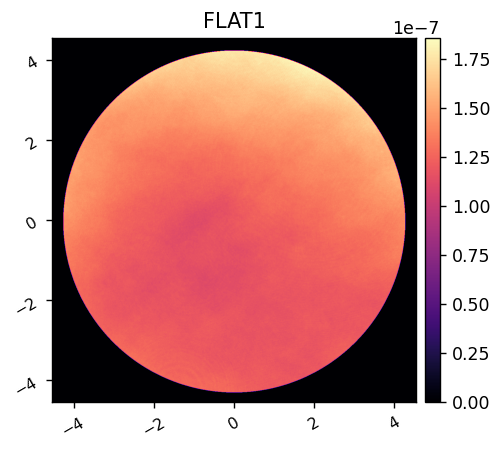

FLAT2.h5
aspect: 1.0
height_units: b'wv'
lut_type: b'opd'
wavelength: b'632.79999999999995000000 nm'
wedge: 0.5
xpix: b'0.00744406805458000010 mm'


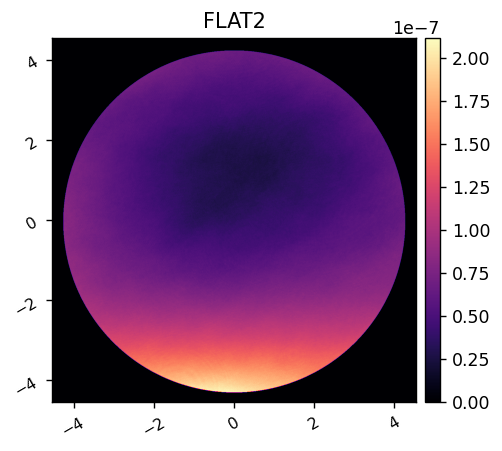

FLAT2_LOOSE.h5
aspect: 1.0
height_units: b'wv'
lut_type: b'opd'
wavelength: b'632.79999999999995000000 nm'
wedge: 0.5
xpix: b'0.00744406805458000010 mm'


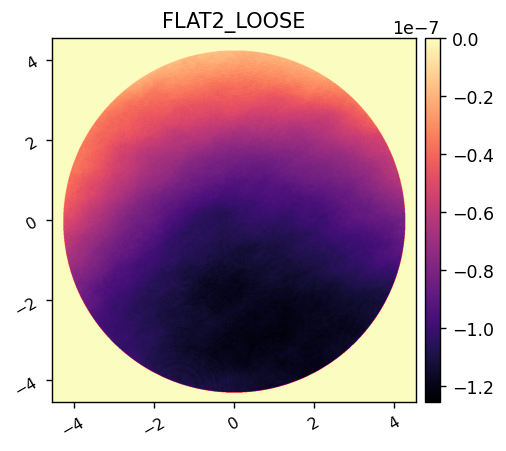

FLAT2_TIGHT.h5
aspect: 1.0
height_units: b'wv'
lut_type: b'opd'
wavelength: b'632.79999999999995000000 nm'
wedge: 0.5
xpix: b'0.00744406805458000010 mm'


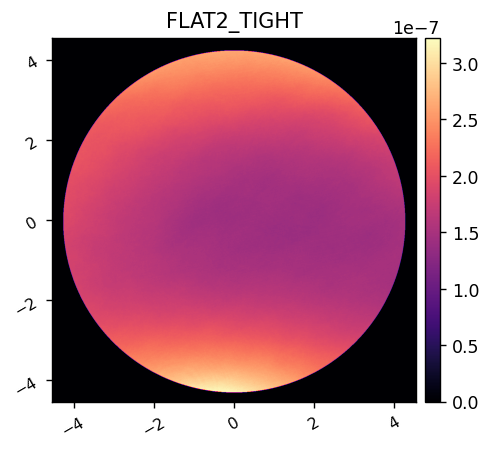

M3.h5
aspect: 1.0
height_units: b'wv'
lut_type: b'opd'
wavelength: b'632.79999999999995000000 nm'
wedge: 0.5
xpix: b'0.00744406805458000010 mm'


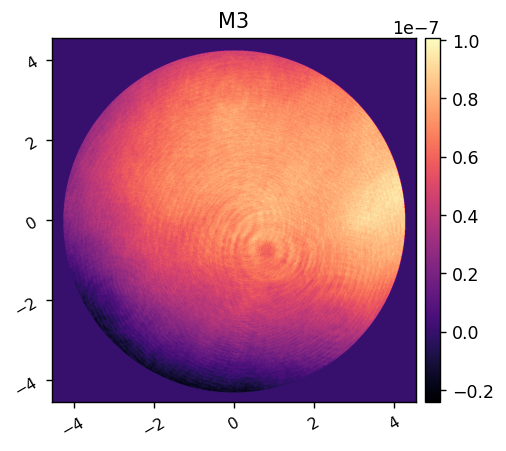

OAP1.h5
aspect: 1.0
height_units: b'wv'
lut_type: b'opd'
wavelength: b'632.79999999999995000000 nm'
wedge: 0.5
xpix: b'0.00744406805458000010 mm'


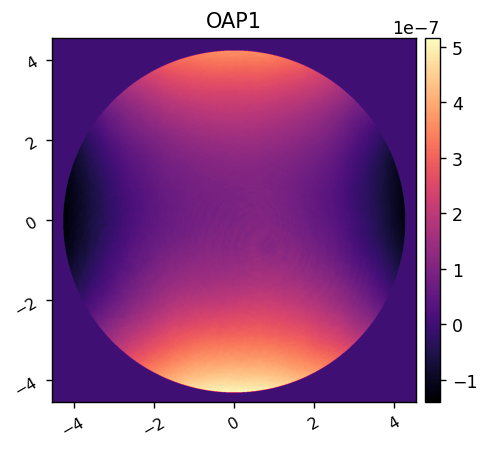

OAP2.h5
aspect: 1.0
height_units: b'wv'
lut_type: b'opd'
wavelength: b'632.79999999999995000000 nm'
wedge: 0.5
xpix: b'0.00744406805458000010 mm'


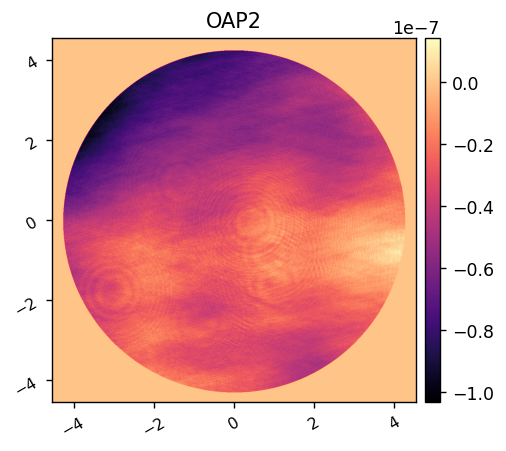

OAP3.h5
aspect: 1.0
height_units: b'wv'
lut_type: b'opd'
wavelength: b'632.79999999999995000000 nm'
wedge: 0.5
xpix: b'0.00744406805458000010 mm'


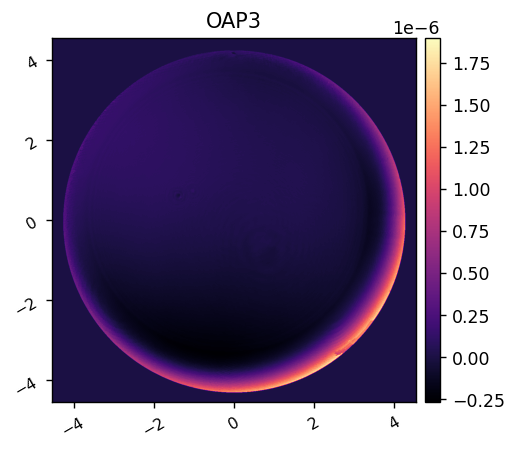

In [2]:
raw_opds = {}

for fname in opd_fnames:
    print(os.path.basename(fname))
    opd_file = h5py.File(fname, mode='r')
    opd_data = np.array(opd_file['measurement0']['genraw']['data'])
    opd_data *= wavelength.value
    opd_mask = opd_data < 1e10
    opd_data[~opd_mask] = 0
    
    attr = opd_file['measurement0']['genraw'].attrs
    attr_list = list(attr)
    for j in range(0, len(attr_list)):
        attr_name = attr_list[j]
        print('{0}: {1}'.format(attr_name, attr[attr_name]))
    
    imshow1(opd_data, os.path.basename(fname)[:-3], pxscl=pixelscale)
    raw_opds[os.path.basename(fname[:-3])] = opd_data * u.m
    
#     hdr = {'ZUNITS':'meters', 'WAVELEN0':650e-9, 'PIXELSCL':0.007444e-3}
#     scoobpsf.utils.save_fits(fname[:-3]+'.fits', opd_data, header=hdr)

In [12]:
def process_opd_data(raw_surf, z_tot=6):
    mask = np.ones_like(raw_surf.value)
    mask[raw_surf==0] = 0
    mask = mask.astype(bool)
#     imshow1(mask)

    # convert surface data to phase
    k_num = wavelength.to(raw_surf.unit)/(2*np.pi*u.radian)
    surf_phase = raw_surf/k_num

    # remove the Zernikes
    z_map, z_weight = zern.calc_zernike_proj(data=surf_phase, nterms=z_tot, mask_full=mask)
    surf_fix_phase = copy.copy(surf_phase)
    for j in range(0, z_tot):
        surf_fix_phase = surf_fix_phase - (z_map[j]*z_weight[j])

    # convert back to surface
    surf_fix = surf_fix_phase*k_num

    # zero mean
    surf_mean = np.mean(surf_fix[mask==True])
    post_surf = surf_fix - surf_mean

    return post_surf, mask

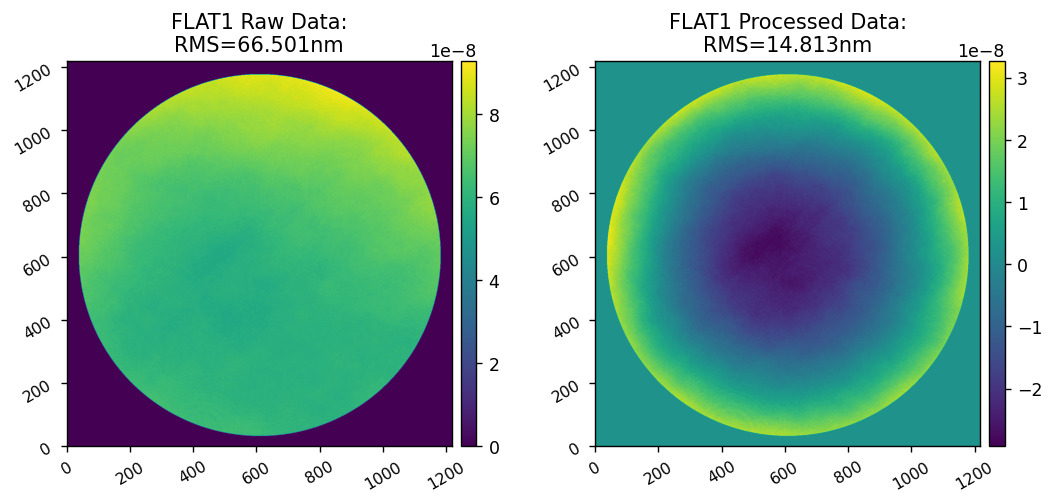

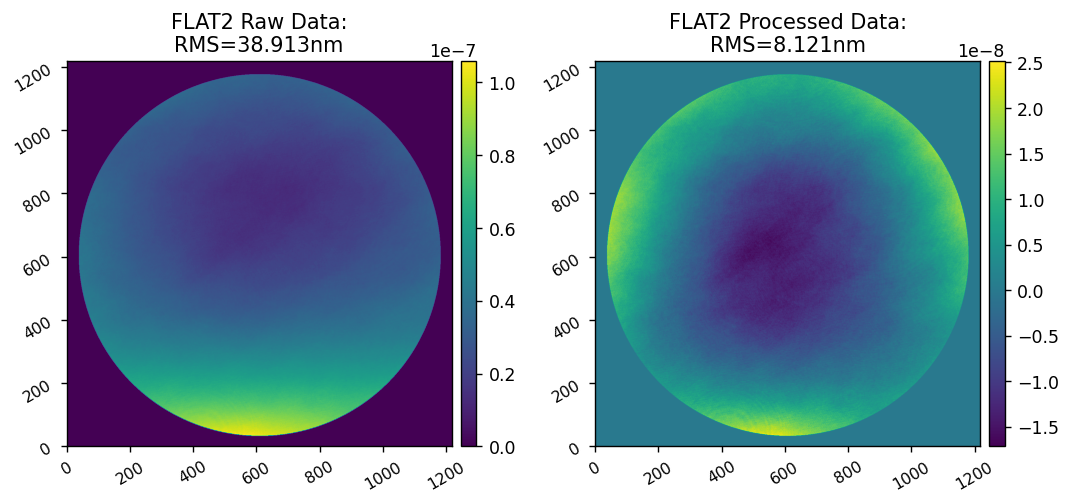

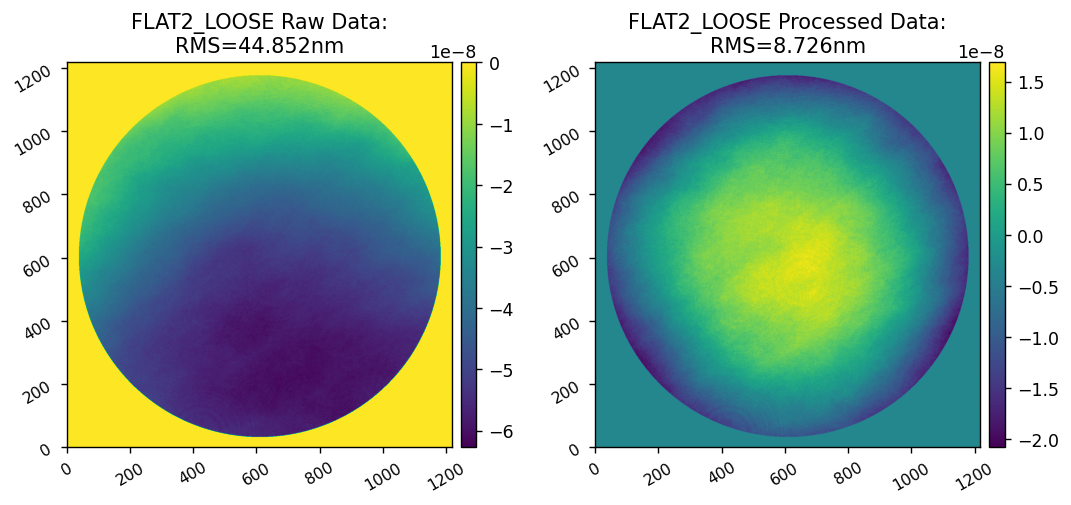

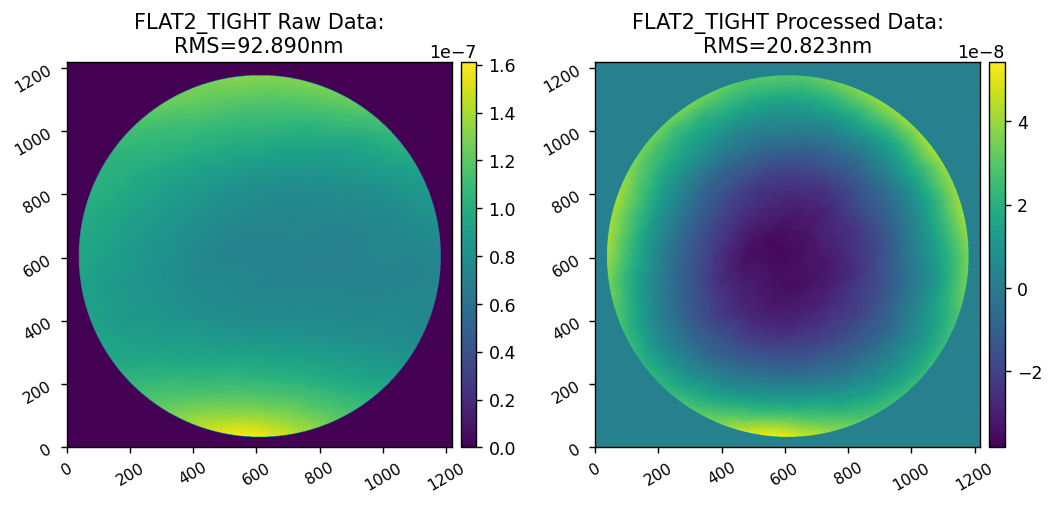

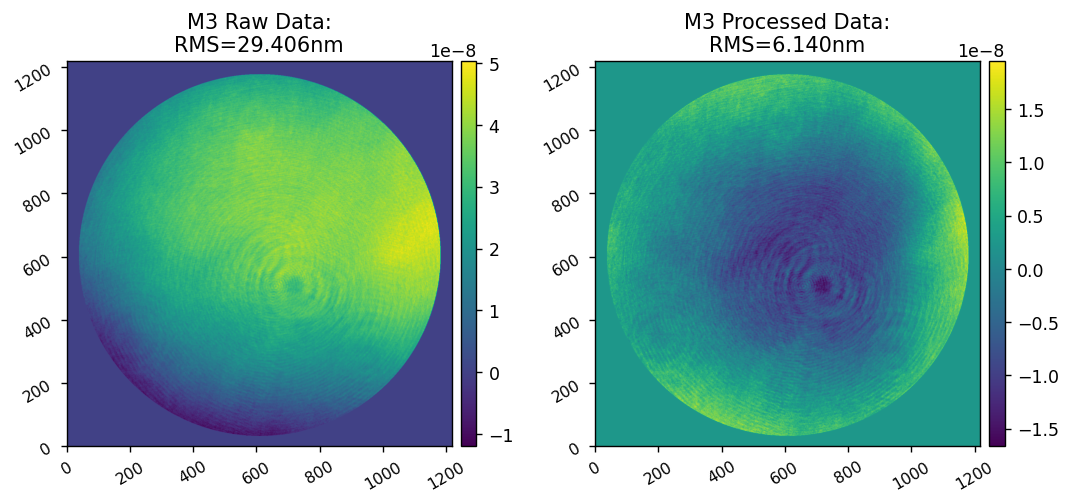

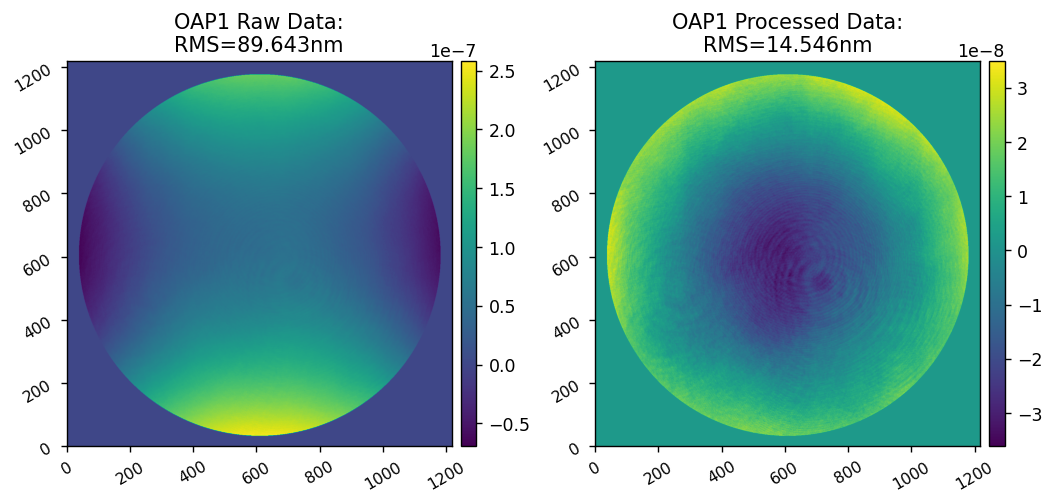

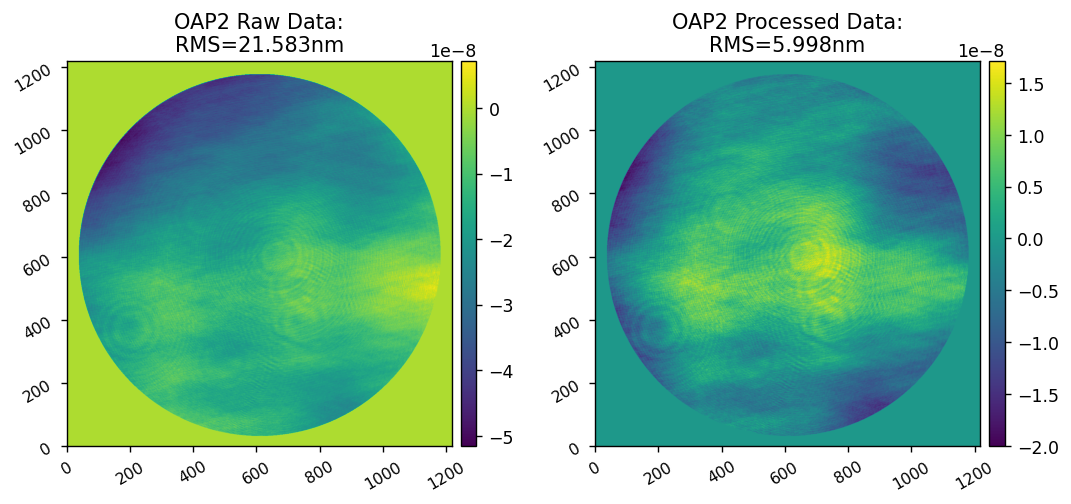

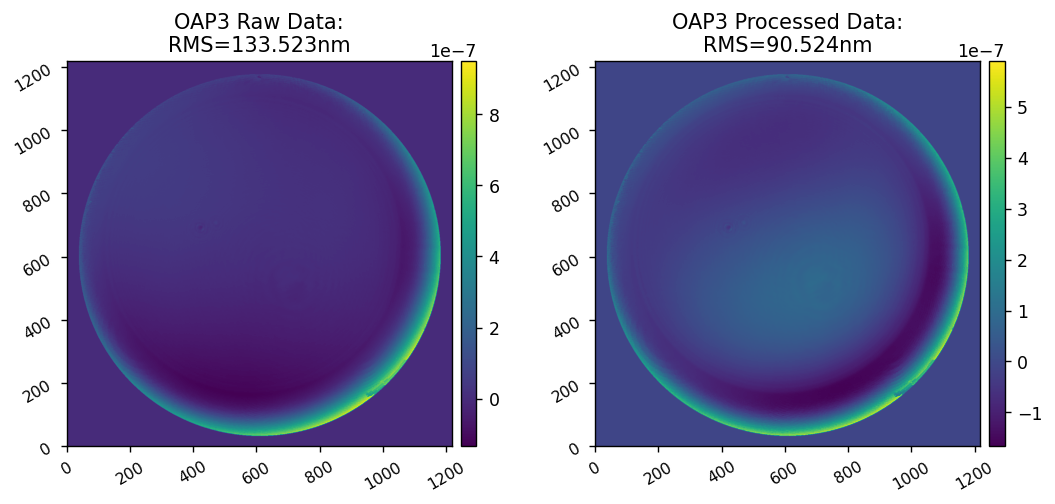

In [16]:
post_opds = {}

keys = list(raw_opds.keys())
for i in range(len(raw_opds)):
    optic_name = keys[i]
    raw_surf = raw_opds[optic_name]/2
    
    if optic_name=='OAP3':
        z_tot = 10
    else:
        z_tot = 6
    
    post_surf, mask = process_opd_data(raw_surf, z_tot=z_tot)

    raw_rms = np.sqrt(np.mean(raw_surf[mask].to_value(u.nm)**2))
    post_rms = np.sqrt(np.mean(post_surf[mask].to_value(u.nm)**2))

    imshow2(raw_surf.value, post_surf.value, 
            f'{optic_name} Raw Data:\nRMS={raw_rms:.3f}nm',  f'{optic_name} Processed Data:\nRMS={post_rms:.3f}nm',
            cmap1='viridis', cmap2='viridis')